# Command Area Targeting Ratio Analysis (Updated Workflow)
This notebook analyzes the targeting of Center Pivot Irrigation Systems (CPIS) within dam command areas across Sub-Saharan Africa, using the workflow from the Dam Analysis folder. It computes observed and expected CPIS area, targeting ratios, and visualizes results at both national and command area levels, including bootstrapped confidence intervals.

## Data Preparation
Load and prepare spatial datasets, standardize CRS, and compute CPIS and irrigated areas for each country and command area.

In [3]:
# Data Preparation: Load and prepare spatial datasets, standardize CRS, and compute CPIS and irrigated areas for each country and command area.
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
import rasterio
import os
import sys

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

projected_crs = "EPSG:3857"
irrig_crs = "EPSG:4326"

# Use consistent dam file and columns
cpis = load_and_reproject(config['SSA_Combined_CPIS_All_shp_path'], projected_crs)
dams = load_and_reproject(config['GDW_Arid_SSA_Final_Irr_shp_path'], projected_crs)
ca = load_and_reproject(config['No_Crop_Vectorized_Command_Area_shp_path'], projected_crs)
arid_ssa = load_and_reproject(config['SSA_Arid_by_Country_shp_path'], irrig_crs)
irrig_raster_path = resolve_path(config['Africa_AEI_2000_asc_path'])

# Filter dams for analysis (ensure column names are consistent)
if 'MAIN_USE' in dams.columns and 'DAM_HGT_M' in dams.columns:
    mask = (dams['DAM_HGT_M'] > 15) & (dams['MAIN_USE'].str.contains('Irrigation', case=False, na=False))
    dams = dams[mask]
else:
    print("Warning: Expected columns 'MAIN_USE' or 'DAM_HGT_M' not found in dams GeoDataFrame.")

# Compute CPIS area per country
cpis['area_m2'] = cpis.geometry.area
if 'Country Co' in cpis.columns:
    cpis.rename(columns={'Country Co': 'ISO'}, inplace=True)
national_cpis = cpis.groupby('ISO')['area_m2'].sum().rename("CPIS_country_area")
national_cpis = national_cpis[national_cpis.index.isin(africa_iso_countries_filtered)]

# Compute irrigated area per country from raster
stats = zonal_stats(arid_ssa, irrig_raster_path, stats=["sum"], geojson_out=True)
irrig_by_country = {f['properties']['ISO']: f['properties']['sum'] for f in stats}
national_irrig = pd.Series(irrig_by_country, name="Irr_country_area")
national_irrig = national_irrig[national_irrig.index.isin(africa_iso_countries_filtered)]
national_irrig *= 10_000  # hectares to m²

# CPIS within each command area (use optimized_clip for efficiency)
ca_proj = ca  # already in projected_crs
cpis_clipped = optimized_clip(cpis, ca_proj)
if not cpis_clipped.empty:
    cpis_ca = gpd.overlay(cpis_clipped, ca_proj, how='intersection')
    cpis_ca['area_m2'] = cpis_ca.geometry.area
    if 'GDW_ID' in cpis_ca.columns:
        cpis_by_dam = cpis_ca.groupby('GDW_ID')['area_m2'].sum().rename("CPIS_in_CA")
    else:
        print("Warning: 'GDW_ID' not found in CPIS command area overlay.")
        cpis_by_dam = pd.Series(dtype=float)
else:
    print("Warning: No CPIS features within command areas after optimized_clip.")
    cpis_by_dam = pd.Series(dtype=float)

# Irrigated area within each command area
ca_zonal = ca.to_crs(irrig_crs)
ca_stats = zonal_stats(ca_zonal, irrig_raster_path, stats=["sum"], geojson_out=False)
ca['Irr_in_CA'] = [s["sum"] for s in ca_stats]
ca['Irr_in_CA'] = ca['Irr_in_CA'] * 10_000  # hectares to m²

## Merge and Calculate Targeting Ratio
Merge datasets, map national stats to command areas, and calculate expected and observed CPIS for targeting ratio analysis.

In [4]:
# Merge command areas, dams, and CPIS
ca_merge = ca.merge(dams[['GDW_ID', 'COUNTRY', 'ISO']], on='GDW_ID', how='left')
ca_indexed = ca_merge.set_index('GDW_ID')
ca_indexed['GDW_ID'] = ca_indexed.index
ca_indexed = ca_indexed.join(cpis_by_dam.rename("CPIS_in_CA")).fillna(0)
ca_indexed['CPIS_country_area'] = ca_indexed['ISO'].map(national_cpis)
ca_indexed['Irr_country_area'] = ca_indexed['ISO'].map(national_irrig)
ca_indexed = ca_indexed[ca_indexed['Irr_country_area'] > 0]

# Expected CPIS and targeting ratio
ca_indexed['Expected_CPIS'] = ca_indexed['Irr_in_CA'] * (
    ca_indexed['CPIS_country_area'] / ca_indexed['Irr_country_area']
)
total_actual = ca_indexed['CPIS_in_CA'].sum()
total_expected = ca_indexed['Expected_CPIS'].sum()
targeting_ratio = total_actual / total_expected if total_expected > 0 else np.nan
print(f"Targeting Ratio: {targeting_ratio:.3f}")

Targeting Ratio: 1.480


## National Targeting Ratio Map
Calculate and plot targeting ratio by country.

In [ ]:
# Compute targeting ratio per country
per_country = pd.DataFrame({
    'CPIS_country_area': national_cpis,
    'Irr_country_area': national_irrig
})
per_country['targeting_ratio'] = per_country['CPIS_country_area'] / per_country['Irr_country_area']

# Merge with the Africa boundaries shapefile
africa_boundaries = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))
africa_boundaries = africa_boundaries.merge(per_country, left_on='ISO', right_index=True, how='left')

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a map with a basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add a basemap (e.g., Natural Earth features)
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Plot the targeting ratio per country
africa_boundaries.plot(
    column='targeting_ratio',
    cmap='RdYlGn',
    legend=True,
    ax=ax,
    transform=ccrs.PlateCarree(),  # Ensure the CRS matches
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Add a title
ax.set_title('National Summary of Center Pivot Alignment with Dams', fontsize=16)
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())  # Set map extent (adjust as needed)

plt.show()

## Command Area Targeting Ratio Map
Calculate and plot targeting ratio for each command area.

In [ ]:
import matplotlib.colors as mcolors

# Calculate targeting ratio for each command area
ca_indexed['targeting_ratio'] = ca_indexed['CPIS_in_CA'] / ca_indexed['Expected_CPIS']

# Merge targeting ratio back with the command area GeoDataFrame
ca_with_ratios = ca.merge(
    ca_indexed[['Expected_CPIS', 'targeting_ratio']], 
    left_on='GDW_ID', 
    right_index=True, 
    how='left'
)

# Calculate centroids of command areas
ca_with_ratios['centroid'] = ca_with_ratios.geometry.centroid

# Create a GeoDataFrame with centroids
ca_points = gpd.GeoDataFrame(ca_with_ratios, geometry='centroid', crs=ca_with_ratios.crs)

# Load the SSA arid shapefile
ssa_arid = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))

# Ensure the CRS matches the points' CRS
ssa_arid = ssa_arid.to_crs(ca_points.crs)

# Define a diverging colormap centered at 1
vmin, vmax = 0, 2  # Set the range of the color scale
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

# Categorize missing or zero targeting ratios
ca_points['reason'] = 'Valid'  # Default category
ca_points.loc[ca_points['Irr_in_CA'] == 0, 'reason'] = 'No Irrigation'
ca_points.loc[ca_points['Expected_CPIS'] == 0, 'reason'] = 'No Command Area'
ca_points.loc[ca_points['targeting_ratio'].isna(), 'reason'] = 'Missing Data'

# Split the data into groups
valid_points = ca_points[ca_points['reason'] == 'Valid']  # Points with valid targeting ratios
no_irrigation_points = ca_points[ca_points['reason'] == 'No Irrigation']
no_command_area_points = ca_points[ca_points['reason'] == 'No Command Area']
missing_data_points = ca_points[ca_points['reason'] == 'Missing Data']

# Plot the SSA arid shapefile (base layer) with a basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add a basemap (e.g., Natural Earth features)
ax.add_feature(cfeature.LAND, facecolor='white')  # Background for arid regions
ax.add_feature(cfeature.BORDERS, edgecolor='black')  # Country borders
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  # Coastlines

# Plot the SSA arid shapefile
ssa_arid.plot(
    ax=ax,
    color="lightgrey",  # Set a background color for the arid regions
    edgecolor="black",    # Add borders for the regions
    alpha=0.7,            # Make it semi-transparent
    label="SSA Arid Regions"
)

# Plot points by category
if not no_irrigation_points.empty:
    no_irrigation_points.plot(
        ax=ax,
        color="blue",
        markersize=10,
        label="No Irrigation"
    )
if not no_command_area_points.empty:
    no_command_area_points.plot(
        ax=ax,
        color="red",
        markersize=10,
        label="No Command Area"
    )
if not missing_data_points.empty:
    missing_data_points.plot(
        ax=ax,
        color="black",
        markersize=10,
        label="Missing Data"
    )

# Plot valid points (colored by targeting ratio) on top
if not valid_points.empty:
    valid_points.plot(
        column='targeting_ratio',
        cmap='RdYlGn',
        legend=True,
        ax=ax,
        norm=norm,  # Use the normalized color scale
        markersize=40,
    )

# Add a title, legend, and remove axes
ax.set_title('Center Pivot Density Around Individual Command Areas', fontsize=16)
ax.legend(loc="lower left", fontsize=10)
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())  # Set map extent (adjust as needed)
plt.show()

## Command Area Irrigation Summary
Show the number and percent of command areas with nonzero irrigation.

In [ ]:
# Count command areas with irrigation
num_with_irrigation = ca_with_ratios[ca_with_ratios['Irr_in_CA'] > 0].shape[0]
total_command_areas = ca_with_ratios.shape[0]

print(f"Number of command areas with irrigation: {num_with_irrigation}")
print(f"Total number of command areas: {total_command_areas}")
print(f"Percentage with irrigation: {num_with_irrigation / total_command_areas * 100:.2f}%")

                area  ResArea  dH       MaxDist     Geom_type  \
GDW_ID                                                          
7072    4.444208e+07   13.432  10   5023.898933  MultiPolygon   
7250    5.882556e+08   12.987  10  68281.066598  MultiPolygon   
2034    2.231729e+09   16.050  10  96081.376451  MultiPolygon   
6910    4.110226e+08   15.521  10  24551.605778  MultiPolygon   
6895    1.592437e+07  132.923  10   5642.971225  MultiPolygon   

                         type  validCA  ResElev  RAreaPct    backupCap  \
GDW_ID                                                                   
7072    vectorized_nocropmask     True      200  0.308606  1589.404847   
7250    vectorized_nocropmask     True      863  1.000000  2489.531954   
2034    vectorized_nocropmask     True      489  1.000000  1785.240539   
6910    vectorized_nocropmask     True      884  1.000000  3305.872150   
6895    vectorized_nocropmask     True      305  0.002437  7235.221248   

           Yield  ResCapB

## Bootstrapping Targeting Ratio Confidence Intervals
Estimate uncertainty in the targeting ratio using bootstrap resampling. Results are shown for overall and by country.

In [ ]:
# Bootstrap for overall targeting ratio
n_bootstrap = 10000
ratios = []
dam_ids = ca_indexed.index.unique()
for _ in range(n_bootstrap):
    resampled = ca_indexed.sample(n=len(dam_ids), replace=True)
    actual = resampled['CPIS_in_CA'].sum()
    expected = resampled['Expected_CPIS'].sum()
    ratio = actual / expected if expected > 0 else np.nan
    ratios.append(ratio)
ratios = np.array(ratios)
ratios = ratios[~np.isnan(ratios)]
ci_low, ci_high = np.percentile(ratios, [2.5, 97.5])
plt.hist(ratios, bins=30, color='skyblue', edgecolor='k')
plt.axvline(ci_low, color='red', linestyle='--', label='95% CI')
plt.axvline(ci_high, color='red', linestyle='--')
plt.axvline(np.median(ratios), color='black', linestyle='-', label='Median')
plt.title('Bootstrap Targeting Ratio (Overall)')
plt.xlabel('Targeting Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print(f"Overall Targeting Ratio 95% CI: ({ci_low:.3f}, {ci_high:.3f})")

# Per-country bootstrap
country_bootstrap = {}
for country in ca_indexed['ISO'].dropna().unique():
    subset = ca_indexed[ca_indexed['ISO'] == country]
    if len(subset) < 2:
        continue
    ratios = []
    for _ in range(n_bootstrap):
        resampled = subset.sample(n=len(subset), replace=True)
        actual = resampled['CPIS_in_CA'].sum()
        expected = resampled['Expected_CPIS'].sum()
        ratio = actual / expected if expected > 0 else np.nan
        ratios.append(ratio)
    ratios = np.array(ratios)
    ratios = ratios[~np.isnan(ratios)]
    if len(ratios) > 0:
        ci_low, ci_high = np.percentile(ratios, [2.5, 97.5])
        country_bootstrap[country] = (np.median(ratios), ci_low, ci_high)
country_ci = pd.DataFrame.from_dict(country_bootstrap, orient='index', columns=['median', 'ci_low', 'ci_high'])
country_ci = country_ci.sort_values('median')
plt.figure(figsize=(8, max(4, len(country_ci)//2)))
plt.errorbar(country_ci['median'], country_ci.index, 
             xerr=[country_ci['median']-country_ci['ci_low'], country_ci['ci_high']-country_ci['median']],
             fmt='o', color='navy', ecolor='red', capsize=3)
plt.axvline(1, color='grey', linestyle='--')
plt.xlabel('Targeting Ratio')
plt.title('Per-Country Targeting Ratio with 95% CI')
plt.tight_layout()
plt.show()

# Print per-country targeting ratio median and 95% CI
print('Per-country Targeting Ratio 95% CI:')
for country, row in country_ci.iterrows():
    print(f"{country}: median={row['median']:.3f}, 95% CI=({row['ci_low']:.3f}, {row['ci_high']:.3f})")

# Exclude South Africa (ZAF) and print again
if 'ZAF' in country_ci.index:
    print('\nPer-country Targeting Ratio 95% CI (excluding South Africa):')
    for country, row in country_ci.drop('ZAF').iterrows():
        print(f"{country}: median={row['median']:.3f}, 95% CI=({row['ci_low']:.3f}, {row['ci_high']:.3f})")

In [ ]:
# Exclude Zimbabwe (ZWE) from ca_indexed
ca_indexed_no_zwe = ca_indexed[ca_indexed['ISO'] != 'ZWE']

# Bootstrap for overall targeting ratio (excluding ZWE)
n_bootstrap = 1000
ratios_no_zwe = []
dam_ids_no_zwe = ca_indexed_no_zwe.index.unique()
for _ in range(n_bootstrap):
    resampled = ca_indexed_no_zwe.sample(n=len(dam_ids_no_zwe), replace=True)
    actual = resampled['CPIS_in_CA'].sum()
    expected = resampled['Expected_CPIS'].sum()
    ratio = actual / expected if expected > 0 else np.nan
    ratios_no_zwe.append(ratio)
ratios_no_zwe = np.array(ratios_no_zwe)
ratios_no_zwe = ratios_no_zwe[~np.isnan(ratios_no_zwe)]
ci_low_no_zwe, ci_high_no_zwe = np.percentile(ratios_no_zwe, [2.5, 97.5])
plt.hist(ratios_no_zwe, bins=30, color='skyblue', edgecolor='k')
plt.axvline(ci_low_no_zwe, color='red', linestyle='--', label='95% CI')
plt.axvline(ci_high_no_zwe, color='red', linestyle='--')
plt.axvline(np.median(ratios_no_zwe), color='black', linestyle='-', label='Median')
plt.title('Bootstrap Targeting Ratio (Overall, Excluding ZWE)')
plt.xlabel('Targeting Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print(f"Overall Targeting Ratio 95% CI (excluding ZWE): ({ci_low_no_zwe:.3f}, {ci_high_no_zwe:.3f})")

# Per-country plot excluding ZWE
country_ci_no_zwe = country_ci.drop('ZWE', errors='ignore')
plt.figure(figsize=(8, max(4, len(country_ci_no_zwe)//2)))
plt.errorbar(country_ci_no_zwe['median'], country_ci_no_zwe.index, 
             xerr=[country_ci_no_zwe['median']-country_ci_no_zwe['ci_low'], country_ci_no_zwe['ci_high']-country_ci_no_zwe['median']],
             fmt='o', color='navy', ecolor='red', capsize=3)
plt.axvline(1, color='grey', linestyle='--')
plt.xlabel('Targeting Ratio')
plt.title('Per-Country Targeting Ratio with 95% CI (Excluding ZWE)')
plt.tight_layout()
plt.show()

## Command Area Targeting Ratio Map
Calculate and plot targeting ratio for each command area.

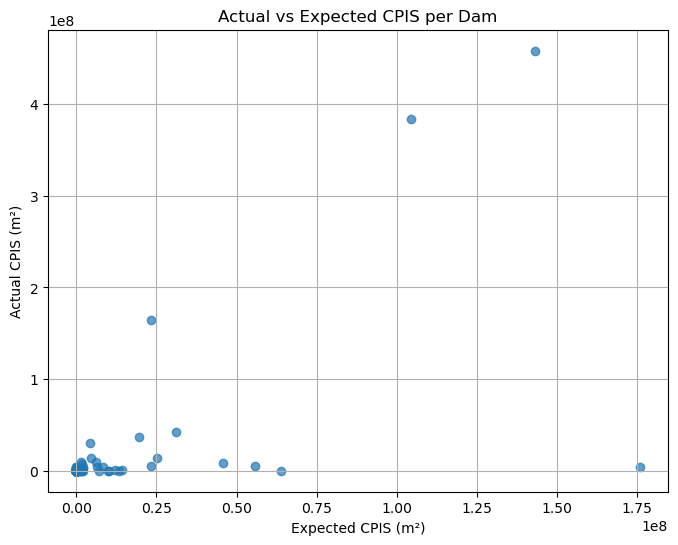

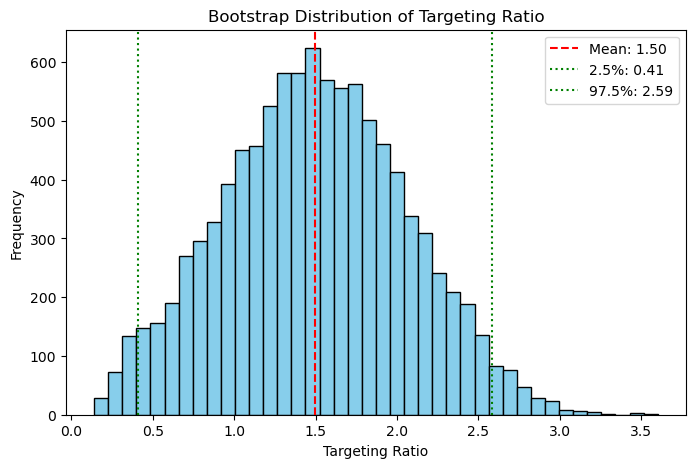


Final Targeting Ratio: 1.498
Mean Targeting Ratio (bootstrap): 1.496
95% CI: (0.411, 2.587)


In [ ]:
# Compute targeting ratio per country
per_country = pd.DataFrame({
    'CPIS_country_area': national_cpis,
    'Irr_country_area': national_irrig
})
per_country['targeting_ratio'] = per_country['CPIS_country_area'] / per_country['Irr_country_area']

# Merge with the Africa boundaries shapefile
africa_boundaries = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))
africa_boundaries = africa_boundaries.merge(per_country, left_on='ISO', right_index=True, how='left')

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a map with a basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add a basemap (e.g., Natural Earth features)
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Plot the targeting ratio per country
africa_boundaries.plot(
    column='targeting_ratio',
    cmap='RdYlGn',
    legend=True,
    ax=ax,
    transform=ccrs.PlateCarree(),  # Ensure the CRS matches
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Add a title
ax.set_title('National Summary of Center Pivot Alignment with Dams', fontsize=16)
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())  # Set map extent (adjust as needed)

plt.show()